In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm  # Import tqdm for the progress bar
import matplotlib.pyplot as plt

In [ ]:
# Define a simple neural network for the MNIST dataset
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

##Standard SGD

In [ ]:
# Function for training with standard mini-batch SGD
def train_standard_sgd(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]: Loss: {loss.item():.6f}")

##SGD with forgetting score (sort and choose m examples from batch b)

In [ ]:
# Function for training with mini-batch SGD considering forgetting score
def train_with_forgetting_score(model, device, train_loader, optimizer, epoch, n_b, prev_acc, forgetting_T):
    model.train()
    total_forgetting_score = 0.0
    m = int(train_loader.batch_size * n_b)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # Save predictions
        with torch.no_grad():
            new_output = model(data)
            new_pred = new_output.argmax(dim=1, keepdim=True) #TODO: compute acci should be done in inner for loop

        # Calculate forgetting score for each image in larger sampling batch
        for i in range(len(data)):

          new_correct = int(new_pred[i].eq(target[i].view_as(new_pred[i])).item()) #see if curr example classified correctly

          index = batch_idx * train_loader.batch_size + i #gets image index
          if prev_acc[index] > new_correct: #previous prediction is correctly classified (true 1) > new prediction misclassified (false 0)
            forgetting_T[index] += 1 #stores forgetting scores

          prev_acc[index] = new_correct #stores whether previous prediction classified correctly or not

        # Sort examples by forgetting score in descending order within the batch
        batch_forgetting_scores = [(i, forgetting_T[i]) for i in range(len(data))]
        batch_forgetting_scores = sorted(batch_forgetting_scores, key=lambda x: x[1], reverse=True)

        # Choose the top m examples with the highest forgetting scores within the batch
        selected_examples = [i for i, _ in batch_forgetting_scores[:m]]

        # Run only the selected examples through the model
        selected_output = model(data[selected_examples])
        selected_target = target[selected_examples]

        loss = nn.functional.cross_entropy(selected_output, selected_target)
        loss.backward()
        optimizer.step()

    #forgetting score
    epoch_forgetting_score = sum(forgetting_T)
    average_forgetting_score = total_forgetting_score / len(forgetting_T)

    # Print current total forgetting score at the end of each iteration
    print(f'Epoch: {epoch}, Batch: {batch_idx}, Average Forgetting Score: {epoch_forgetting_score}')

    return average_forgetting_score

##SGD with forgetting score (probabilistically determine m examples from batch b)

In [ ]:
# Function for training with mini-batch SGD considering forgetting score
def train_with_forgetting_score_probabilistic(model, device, train_loader, optimizer, epoch, n_b, prev_acc, forgetting_T, random=False):
    model.train()
    total_forgetting_score = 0.0
    m = int(train_loader.batch_size * n_b)
    for batch_idx, (data, target) in enumerate(train_loader):
        # Sample m points from b based on forgetting score
        forgetting_scores = forgetting_T[batch_idx * train_loader.batch_size: batch_idx * train_loader.batch_size + len(data) - 1] + 1
        forgetting_probs = forgetting_scores / sum(forgetting_scores) if not random else torch.ones(len(data)) / len(data)
        sampled_indices = torch.multinomial(forgetting_probs, m, replacement=False)

        # Get selected data
        selected_data = torch.index_select(data, 0, sampled_indices).to(device)
        selected_target = torch.index_select(target, 0, sampled_indices).to(device)

        # Save predictions
        with torch.no_grad():
            new_output = model(selected_data)
            new_pred = new_output.argmax(dim=1, keepdim=True) #TODO: compute acci should be done in inner for loop

        for idx, i in enumerate(sampled_indices):
          new_correct = int(new_pred[idx].eq(selected_target[idx].view_as(new_pred[idx])).item())

          index = batch_idx * train_loader.batch_size + i #Get image index
          if prev_acc[index] > new_correct: #previous prediction is correctly classified (true 1) > new prediction misclassified (false 0)
            forgetting_T[index] += 1

          # if prev_acc[index] > new_correct: #check
          #   print(f"index: {index} --- prev predict: {prev_acc[index]} --- new_predict: {new_correct} --- curr forgetting: {forgetting_T[index]}")

          prev_acc[index] = new_correct

        # Perform a training step (gradient update classifier on m out of B)
        optimizer.zero_grad()
        output = model(selected_data)
        loss = nn.functional.cross_entropy(output, selected_target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} [{batch_idx * len(selected_data)}/{n_b * len(train_loader.dataset)}]: Loss: {loss.item():.6f}")

    #forgetting score
    epoch_forgetting_score = sum(forgetting_T)
    average_forgetting_score = epoch_forgetting_score / len(forgetting_T)

    # Print current total forgetting score at the end of each iteration
    # print(f'Epoch: {epoch}, Batch: {batch_idx}, Average Forgetting Score: {epoch_forgetting_score}')

    return average_forgetting_score

##Run different methods

In [ ]:
# Function for testing the model on the test dataset
def test_model(model, device, test_loader):
    """
    Tests model given the test set in test_loader

    Args:
      model:    model to be tested
      device:   cpu or cuda if available
      test_loader:
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    accuracy = correct / total
    return accuracy

# Main function to run the training
def run_training(batch_size, n_b, epochs):
    """
    Trains the SimpleNN() using various methods of online batch selection

    Args:
        batch_size (int): batch size for gradient descent
        n_b        (int): fraction of mini-batch chosen for training
        epochs     (int): number of epochs to train for

    Returns:
        test_accuracies Dict[Str -> List[int]]: Dictionary of testing accuracies for each model
          keys:
            'standard':         standard mini-batch SGD model
            'prob-forgetting':  creating sampling distribution using forgetting score
            'sort-forgetting':  selecting highest forgetting scores
            'random':           select random n_b subset
    """
    # Check for available device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    prev_acc = torch.zeros_like(train_dataset.targets)
    forgetting_T = torch.zeros_like(train_dataset.targets)


    # Initialize models and optimizers
    standard_model = SimpleNN().to(device)
    forgetting_model = SimpleNN().to(device)
    random_model = SimpleNN().to(device)
    optimizer_standard = optim.SGD(standard_model.parameters(), lr=0.01, momentum = 0.5)
    optimizer_forgetting = optim.SGD(forgetting_model.parameters(), lr=0.01, momentum = 0.5)
    optimizer_random = optim.SGD(random_model.parameters(), lr=0.01, momentum = 0.5)


    # Lists to store test accuracies
    test_accuracies = {
        'standard' : [],
        'prob-forgetting': [],
        'sort-forgetting': [],
        'random': []
    }

    # get initial loss
    test_acc_standard = test_model(standard_model, device, test_loader)
    test_accuracies['standard'].append(test_acc_standard)

    test_acc_forgetting = test_model(forgetting_model, device, test_loader)
    test_accuracies['prob-forgetting'].append(test_acc_forgetting)

    # Train models

    # standard
    for epoch in tqdm(range(1, epochs + 1), desc='Epochs'):
        print(f"\nEpoch {epoch} - Standard SGD")
        train_standard_sgd(standard_model, device, train_loader, optimizer_standard, epoch)

        test_acc_standard = test_model(standard_model, device, test_loader)
        test_accuracies['standard'].append(test_acc_standard)

    # probabilistic forgetting
    for epoch in tqdm(range(1, epochs + 1), desc='Epochs'):
        print(f"\nEpoch {epoch} - SGD with Forgetting Score")
        avg_forgetting_score = train_with_forgetting_score_probabilistic(
            forgetting_model,
            device,
            train_loader,
            optimizer_forgetting,
            epoch,
            n_b,
            prev_acc,
            forgetting_T,random=False)

        test_acc_forgetting = test_model(forgetting_model, device, test_loader)
        test_accuracies['prob-forgetting'].append(test_acc_forgetting)

    # random selection
    for epoch in tqdm(range(1, epochs + 1), desc='Epochs'):
        print(f"\nEpoch {epoch} - SGD with Random Selection")
        avg_forgetting_score = train_with_forgetting_score_probabilistic(
            random_model,
            device,
            train_loader,
            optimizer_random,
            epoch,
            n_b,
            prev_acc,
            forgetting_T,
            random=True)

        test_acc_random = test_model(random_model, device, test_loader)
        test_accuracies['random'].append(test_acc_random)

    return test_accuracies

# Parameters for training
batch_size = 64
epochs = 15 #100
n_b = 0.1

# Start training
test_accuracies = run_training(batch_size, n_b, epochs)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1 - Standard SGD
Epoch 1 [0/60000]: Loss: 2.325728
Epoch 1 [6400/60000]: Loss: 1.575096
Epoch 1 [12800/60000]: Loss: 0.719903
Epoch 1 [19200/60000]: Loss: 0.476280
Epoch 1 [25600/60000]: Loss: 0.504243
Epoch 1 [32000/60000]: Loss: 0.397032
Epoch 1 [38400/60000]: Loss: 0.549147
Epoch 1 [44800/60000]: Loss: 0.234844
Epoch 1 [51200/60000]: Loss: 0.222701
Epoch 1 [57600/60000]: Loss: 0.255737


Epochs:   7%|▋         | 1/15 [00:40<09:21, 40.10s/it]


Epoch 2 - Standard SGD
Epoch 2 [0/60000]: Loss: 0.303467
Epoch 2 [6400/60000]: Loss: 0.350941
Epoch 2 [12800/60000]: Loss: 0.204962
Epoch 2 [19200/60000]: Loss: 0.382689
Epoch 2 [25600/60000]: Loss: 0.352904
Epoch 2 [32000/60000]: Loss: 0.447278
Epoch 2 [38400/60000]: Loss: 0.118429
Epoch 2 [44800/60000]: Loss: 0.155265
Epoch 2 [51200/60000]: Loss: 0.313261
Epoch 2 [57600/60000]: Loss: 0.230572


Epochs:  13%|█▎        | 2/15 [01:20<08:40, 40.03s/it]


Epoch 3 - Standard SGD
Epoch 3 [0/60000]: Loss: 0.092094
Epoch 3 [6400/60000]: Loss: 0.129483
Epoch 3 [12800/60000]: Loss: 0.323595
Epoch 3 [19200/60000]: Loss: 0.114538
Epoch 3 [25600/60000]: Loss: 0.156037
Epoch 3 [32000/60000]: Loss: 0.115204
Epoch 3 [38400/60000]: Loss: 0.217162
Epoch 3 [44800/60000]: Loss: 0.117769
Epoch 3 [51200/60000]: Loss: 0.090936
Epoch 3 [57600/60000]: Loss: 0.087795


Epochs:  20%|██        | 3/15 [02:00<08:01, 40.15s/it]


Epoch 4 - Standard SGD
Epoch 4 [0/60000]: Loss: 0.131129
Epoch 4 [6400/60000]: Loss: 0.100456
Epoch 4 [12800/60000]: Loss: 0.121599
Epoch 4 [19200/60000]: Loss: 0.038570
Epoch 4 [25600/60000]: Loss: 0.148747
Epoch 4 [32000/60000]: Loss: 0.118361
Epoch 4 [38400/60000]: Loss: 0.098433
Epoch 4 [44800/60000]: Loss: 0.310035
Epoch 4 [51200/60000]: Loss: 0.091079
Epoch 4 [57600/60000]: Loss: 0.087530


Epochs:  27%|██▋       | 4/15 [02:40<07:20, 40.05s/it]


Epoch 5 - Standard SGD
Epoch 5 [0/60000]: Loss: 0.110517
Epoch 5 [6400/60000]: Loss: 0.198237
Epoch 5 [12800/60000]: Loss: 0.289295
Epoch 5 [19200/60000]: Loss: 0.182219
Epoch 5 [25600/60000]: Loss: 0.211511
Epoch 5 [32000/60000]: Loss: 0.176380
Epoch 5 [38400/60000]: Loss: 0.178644
Epoch 5 [44800/60000]: Loss: 0.268721
Epoch 5 [51200/60000]: Loss: 0.188496
Epoch 5 [57600/60000]: Loss: 0.133488


Epochs:  33%|███▎      | 5/15 [03:20<06:40, 40.07s/it]


Epoch 6 - Standard SGD
Epoch 6 [0/60000]: Loss: 0.171332
Epoch 6 [6400/60000]: Loss: 0.261572
Epoch 6 [12800/60000]: Loss: 0.116856
Epoch 6 [19200/60000]: Loss: 0.099105
Epoch 6 [25600/60000]: Loss: 0.160778
Epoch 6 [32000/60000]: Loss: 0.109883
Epoch 6 [38400/60000]: Loss: 0.275596
Epoch 6 [44800/60000]: Loss: 0.104024
Epoch 6 [51200/60000]: Loss: 0.083848
Epoch 6 [57600/60000]: Loss: 0.077602


Epochs:  40%|████      | 6/15 [04:00<06:01, 40.15s/it]


Epoch 7 - Standard SGD
Epoch 7 [0/60000]: Loss: 0.280180
Epoch 7 [6400/60000]: Loss: 0.144484
Epoch 7 [12800/60000]: Loss: 0.074925
Epoch 7 [19200/60000]: Loss: 0.268663
Epoch 7 [25600/60000]: Loss: 0.119562
Epoch 7 [32000/60000]: Loss: 0.048337
Epoch 7 [38400/60000]: Loss: 0.039933
Epoch 7 [44800/60000]: Loss: 0.101452
Epoch 7 [51200/60000]: Loss: 0.164829
Epoch 7 [57600/60000]: Loss: 0.030497


Epochs:  47%|████▋     | 7/15 [04:40<05:20, 40.09s/it]


Epoch 8 - Standard SGD
Epoch 8 [0/60000]: Loss: 0.082631
Epoch 8 [6400/60000]: Loss: 0.087284
Epoch 8 [12800/60000]: Loss: 0.211911
Epoch 8 [19200/60000]: Loss: 0.057301
Epoch 8 [25600/60000]: Loss: 0.071389
Epoch 8 [32000/60000]: Loss: 0.147440
Epoch 8 [38400/60000]: Loss: 0.083923
Epoch 8 [44800/60000]: Loss: 0.078535
Epoch 8 [51200/60000]: Loss: 0.073894
Epoch 8 [57600/60000]: Loss: 0.043170


Epochs:  53%|█████▎    | 8/15 [05:19<04:37, 39.65s/it]


Epoch 9 - Standard SGD
Epoch 9 [0/60000]: Loss: 0.120228
Epoch 9 [6400/60000]: Loss: 0.041692
Epoch 9 [12800/60000]: Loss: 0.059230
Epoch 9 [19200/60000]: Loss: 0.165194
Epoch 9 [25600/60000]: Loss: 0.091856
Epoch 9 [32000/60000]: Loss: 0.058723
Epoch 9 [38400/60000]: Loss: 0.057610
Epoch 9 [44800/60000]: Loss: 0.109044
Epoch 9 [51200/60000]: Loss: 0.184288
Epoch 9 [57600/60000]: Loss: 0.228706


Epochs:  60%|██████    | 9/15 [05:59<03:58, 39.78s/it]


Epoch 10 - Standard SGD
Epoch 10 [0/60000]: Loss: 0.120563
Epoch 10 [6400/60000]: Loss: 0.149085
Epoch 10 [12800/60000]: Loss: 0.048320
Epoch 10 [19200/60000]: Loss: 0.020629
Epoch 10 [25600/60000]: Loss: 0.074322
Epoch 10 [32000/60000]: Loss: 0.082760
Epoch 10 [38400/60000]: Loss: 0.115723
Epoch 10 [44800/60000]: Loss: 0.047402
Epoch 10 [51200/60000]: Loss: 0.059971
Epoch 10 [57600/60000]: Loss: 0.094496


Epochs:  67%|██████▋   | 10/15 [06:39<03:19, 39.87s/it]


Epoch 11 - Standard SGD
Epoch 11 [0/60000]: Loss: 0.090804
Epoch 11 [6400/60000]: Loss: 0.082819
Epoch 11 [12800/60000]: Loss: 0.132522
Epoch 11 [19200/60000]: Loss: 0.079546
Epoch 11 [25600/60000]: Loss: 0.043447
Epoch 11 [32000/60000]: Loss: 0.083924
Epoch 11 [38400/60000]: Loss: 0.084494
Epoch 11 [44800/60000]: Loss: 0.264196
Epoch 11 [51200/60000]: Loss: 0.132778
Epoch 11 [57600/60000]: Loss: 0.232577


Epochs:  73%|███████▎  | 11/15 [07:18<02:38, 39.70s/it]


Epoch 12 - Standard SGD
Epoch 12 [0/60000]: Loss: 0.115341
Epoch 12 [6400/60000]: Loss: 0.143114
Epoch 12 [12800/60000]: Loss: 0.247244
Epoch 12 [19200/60000]: Loss: 0.147856
Epoch 12 [25600/60000]: Loss: 0.062700
Epoch 12 [32000/60000]: Loss: 0.124491
Epoch 12 [38400/60000]: Loss: 0.174159
Epoch 12 [44800/60000]: Loss: 0.078334
Epoch 12 [51200/60000]: Loss: 0.011537
Epoch 12 [57600/60000]: Loss: 0.166626


Epochs:  80%|████████  | 12/15 [07:57<01:58, 39.39s/it]


Epoch 13 - Standard SGD
Epoch 13 [0/60000]: Loss: 0.038672
Epoch 13 [6400/60000]: Loss: 0.069497
Epoch 13 [12800/60000]: Loss: 0.169786
Epoch 13 [19200/60000]: Loss: 0.102383
Epoch 13 [25600/60000]: Loss: 0.142927
Epoch 13 [32000/60000]: Loss: 0.055078
Epoch 13 [38400/60000]: Loss: 0.200195
Epoch 13 [44800/60000]: Loss: 0.116337
Epoch 13 [51200/60000]: Loss: 0.092687
Epoch 13 [57600/60000]: Loss: 0.047591


Epochs:  87%|████████▋ | 13/15 [08:37<01:19, 39.59s/it]


Epoch 14 - Standard SGD
Epoch 14 [0/60000]: Loss: 0.045776
Epoch 14 [6400/60000]: Loss: 0.017595
Epoch 14 [12800/60000]: Loss: 0.065682
Epoch 14 [19200/60000]: Loss: 0.078776
Epoch 14 [25600/60000]: Loss: 0.035715
Epoch 14 [32000/60000]: Loss: 0.026082
Epoch 14 [38400/60000]: Loss: 0.195013
Epoch 14 [44800/60000]: Loss: 0.321607
Epoch 14 [51200/60000]: Loss: 0.088343
Epoch 14 [57600/60000]: Loss: 0.061373


Epochs:  93%|█████████▎| 14/15 [09:17<00:39, 39.73s/it]


Epoch 15 - Standard SGD
Epoch 15 [0/60000]: Loss: 0.034121
Epoch 15 [6400/60000]: Loss: 0.050311
Epoch 15 [12800/60000]: Loss: 0.142675
Epoch 15 [19200/60000]: Loss: 0.026714
Epoch 15 [25600/60000]: Loss: 0.037636
Epoch 15 [32000/60000]: Loss: 0.060366
Epoch 15 [38400/60000]: Loss: 0.038356
Epoch 15 [44800/60000]: Loss: 0.025002
Epoch 15 [51200/60000]: Loss: 0.060745
Epoch 15 [57600/60000]: Loss: 0.042999


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1 - SGD with Forgetting Score
Epoch 1 [0/6000.0]: Loss: 2.288128
Epoch 1 [600/6000.0]: Loss: 1.818779
Epoch 1 [1200/6000.0]: Loss: 1.457673
Epoch 1 [1800/6000.0]: Loss: 0.625870
Epoch 1 [2400/6000.0]: Loss: 1.221676
Epoch 1 [3000/6000.0]: Loss: 0.463153
Epoch 1 [3600/6000.0]: Loss: 0.503862
Epoch 1 [4200/6000.0]: Loss: 0.229606
Epoch 1 [4800/6000.0]: Loss: 0.854436
Epoch 1 [5400/6000.0]: Loss: 0.144674


Epochs:   7%|▋         | 1/15 [00:26<06:14, 26.72s/it]


Epoch 2 - SGD with Forgetting Score
Epoch 2 [0/6000.0]: Loss: 0.268362
Epoch 2 [600/6000.0]: Loss: 0.452016
Epoch 2 [1200/6000.0]: Loss: 1.030950
Epoch 2 [1800/6000.0]: Loss: 0.310233
Epoch 2 [2400/6000.0]: Loss: 1.921556
Epoch 2 [3000/6000.0]: Loss: 0.125749
Epoch 2 [3600/6000.0]: Loss: 0.177132
Epoch 2 [4200/6000.0]: Loss: 0.135376
Epoch 2 [4800/6000.0]: Loss: 0.017874
Epoch 2 [5400/6000.0]: Loss: 0.237731


Epochs:  13%|█▎        | 2/15 [00:53<05:48, 26.84s/it]


Epoch 3 - SGD with Forgetting Score
Epoch 3 [0/6000.0]: Loss: 0.642842
Epoch 3 [600/6000.0]: Loss: 1.186821
Epoch 3 [1200/6000.0]: Loss: 0.421690
Epoch 3 [1800/6000.0]: Loss: 0.074255
Epoch 3 [2400/6000.0]: Loss: 0.080090
Epoch 3 [3000/6000.0]: Loss: 0.049573
Epoch 3 [3600/6000.0]: Loss: 1.663980
Epoch 3 [4200/6000.0]: Loss: 0.114729
Epoch 3 [4800/6000.0]: Loss: 0.020211
Epoch 3 [5400/6000.0]: Loss: 0.456957


Epochs:  20%|██        | 3/15 [01:19<05:16, 26.34s/it]


Epoch 4 - SGD with Forgetting Score
Epoch 4 [0/6000.0]: Loss: 0.294898
Epoch 4 [600/6000.0]: Loss: 0.066256
Epoch 4 [1200/6000.0]: Loss: 0.171684
Epoch 4 [1800/6000.0]: Loss: 0.671615
Epoch 4 [2400/6000.0]: Loss: 0.025982
Epoch 4 [3000/6000.0]: Loss: 0.086847
Epoch 4 [3600/6000.0]: Loss: 0.435608
Epoch 4 [4200/6000.0]: Loss: 0.039607
Epoch 4 [4800/6000.0]: Loss: 1.398932
Epoch 4 [5400/6000.0]: Loss: 0.075432


Epochs:  27%|██▋       | 4/15 [01:44<04:45, 25.98s/it]


Epoch 5 - SGD with Forgetting Score
Epoch 5 [0/6000.0]: Loss: 0.002092
Epoch 5 [600/6000.0]: Loss: 0.098545
Epoch 5 [1200/6000.0]: Loss: 0.060955
Epoch 5 [1800/6000.0]: Loss: 0.355865
Epoch 5 [2400/6000.0]: Loss: 0.013365
Epoch 5 [3000/6000.0]: Loss: 0.027163
Epoch 5 [3600/6000.0]: Loss: 0.150741
Epoch 5 [4200/6000.0]: Loss: 0.327356
Epoch 5 [4800/6000.0]: Loss: 0.025523
Epoch 5 [5400/6000.0]: Loss: 0.006714


Epochs:  33%|███▎      | 5/15 [02:10<04:19, 25.92s/it]


Epoch 6 - SGD with Forgetting Score
Epoch 6 [0/6000.0]: Loss: 0.087810
Epoch 6 [600/6000.0]: Loss: 0.306741
Epoch 6 [1200/6000.0]: Loss: 0.011014
Epoch 6 [1800/6000.0]: Loss: 0.295749
Epoch 6 [2400/6000.0]: Loss: 0.000951
Epoch 6 [3000/6000.0]: Loss: 0.275454
Epoch 6 [3600/6000.0]: Loss: 0.006247
Epoch 6 [4200/6000.0]: Loss: 0.167723
Epoch 6 [4800/6000.0]: Loss: 0.128710
Epoch 6 [5400/6000.0]: Loss: 0.440191


Epochs:  40%|████      | 6/15 [02:36<03:52, 25.82s/it]


Epoch 7 - SGD with Forgetting Score
Epoch 7 [0/6000.0]: Loss: 0.012181
Epoch 7 [600/6000.0]: Loss: 0.006686
Epoch 7 [1200/6000.0]: Loss: 0.018574
Epoch 7 [1800/6000.0]: Loss: 0.201092
Epoch 7 [2400/6000.0]: Loss: 0.014328
Epoch 7 [3000/6000.0]: Loss: 0.318835
Epoch 7 [3600/6000.0]: Loss: 0.107507
Epoch 7 [4200/6000.0]: Loss: 0.103407
Epoch 7 [4800/6000.0]: Loss: 0.003777
Epoch 7 [5400/6000.0]: Loss: 0.032969


Epochs:  47%|████▋     | 7/15 [03:01<03:26, 25.78s/it]


Epoch 8 - SGD with Forgetting Score
Epoch 8 [0/6000.0]: Loss: 0.480244
Epoch 8 [600/6000.0]: Loss: 0.181950
Epoch 8 [1200/6000.0]: Loss: 0.012777
Epoch 8 [1800/6000.0]: Loss: 0.007978
Epoch 8 [2400/6000.0]: Loss: 0.019277
Epoch 8 [3000/6000.0]: Loss: 0.086050
Epoch 8 [3600/6000.0]: Loss: 0.836358
Epoch 8 [4200/6000.0]: Loss: 0.024972
Epoch 8 [4800/6000.0]: Loss: 0.904779
Epoch 8 [5400/6000.0]: Loss: 0.007148


Epochs:  53%|█████▎    | 8/15 [03:27<03:00, 25.82s/it]


Epoch 9 - SGD with Forgetting Score
Epoch 9 [0/6000.0]: Loss: 0.012753
Epoch 9 [600/6000.0]: Loss: 0.093897
Epoch 9 [1200/6000.0]: Loss: 0.059498
Epoch 9 [1800/6000.0]: Loss: 0.517825
Epoch 9 [2400/6000.0]: Loss: 0.020816
Epoch 9 [3000/6000.0]: Loss: 0.203239
Epoch 9 [3600/6000.0]: Loss: 1.701125
Epoch 9 [4200/6000.0]: Loss: 0.084006
Epoch 9 [4800/6000.0]: Loss: 0.372994
Epoch 9 [5400/6000.0]: Loss: 0.981076


Epochs:  60%|██████    | 9/15 [03:53<02:34, 25.75s/it]


Epoch 10 - SGD with Forgetting Score
Epoch 10 [0/6000.0]: Loss: 0.014608
Epoch 10 [600/6000.0]: Loss: 0.111736
Epoch 10 [1200/6000.0]: Loss: 0.021208
Epoch 10 [1800/6000.0]: Loss: 0.063447
Epoch 10 [2400/6000.0]: Loss: 0.001152
Epoch 10 [3000/6000.0]: Loss: 0.001153
Epoch 10 [3600/6000.0]: Loss: 0.001380
Epoch 10 [4200/6000.0]: Loss: 0.018368
Epoch 10 [4800/6000.0]: Loss: 1.977893
Epoch 10 [5400/6000.0]: Loss: 0.157105


Epochs:  67%|██████▋   | 10/15 [04:19<02:08, 25.75s/it]


Epoch 11 - SGD with Forgetting Score
Epoch 11 [0/6000.0]: Loss: 0.015939
Epoch 11 [600/6000.0]: Loss: 0.126463
Epoch 11 [1200/6000.0]: Loss: 0.000134
Epoch 11 [1800/6000.0]: Loss: 0.433043
Epoch 11 [2400/6000.0]: Loss: 0.025516
Epoch 11 [3000/6000.0]: Loss: 0.035037
Epoch 11 [3600/6000.0]: Loss: 0.353109
Epoch 11 [4200/6000.0]: Loss: 0.001498
Epoch 11 [4800/6000.0]: Loss: 0.017922
Epoch 11 [5400/6000.0]: Loss: 0.020527


Epochs:  73%|███████▎  | 11/15 [04:44<01:42, 25.69s/it]


Epoch 12 - SGD with Forgetting Score
Epoch 12 [0/6000.0]: Loss: 0.079704
Epoch 12 [600/6000.0]: Loss: 0.003654
Epoch 12 [1200/6000.0]: Loss: 0.004793
Epoch 12 [1800/6000.0]: Loss: 0.001702
Epoch 12 [2400/6000.0]: Loss: 0.001770
Epoch 12 [3000/6000.0]: Loss: 0.293832
Epoch 12 [3600/6000.0]: Loss: 0.786430
Epoch 12 [4200/6000.0]: Loss: 0.000159
Epoch 12 [4800/6000.0]: Loss: 0.103390
Epoch 12 [5400/6000.0]: Loss: 0.138523


Epochs:  80%|████████  | 12/15 [05:10<01:16, 25.66s/it]


Epoch 13 - SGD with Forgetting Score
Epoch 13 [0/6000.0]: Loss: 0.006016
Epoch 13 [600/6000.0]: Loss: 0.001741
Epoch 13 [1200/6000.0]: Loss: 0.010618
Epoch 13 [1800/6000.0]: Loss: 0.802349
Epoch 13 [2400/6000.0]: Loss: 0.095207
Epoch 13 [3000/6000.0]: Loss: 0.107697
Epoch 13 [3600/6000.0]: Loss: 0.286849
Epoch 13 [4200/6000.0]: Loss: 0.000021
Epoch 13 [4800/6000.0]: Loss: 0.563151
Epoch 13 [5400/6000.0]: Loss: 0.003769


Epochs:  87%|████████▋ | 13/15 [05:35<00:51, 25.59s/it]


Epoch 14 - SGD with Forgetting Score
Epoch 14 [0/6000.0]: Loss: 0.040849
Epoch 14 [600/6000.0]: Loss: 0.003343
Epoch 14 [1200/6000.0]: Loss: 0.154724
Epoch 14 [1800/6000.0]: Loss: 0.870180
Epoch 14 [2400/6000.0]: Loss: 0.034116
Epoch 14 [3000/6000.0]: Loss: 0.000689
Epoch 14 [3600/6000.0]: Loss: 0.032317
Epoch 14 [4200/6000.0]: Loss: 0.200735
Epoch 14 [4800/6000.0]: Loss: 0.000032
Epoch 14 [5400/6000.0]: Loss: 0.005319


Epochs:  93%|█████████▎| 14/15 [06:01<00:25, 25.64s/it]


Epoch 15 - SGD with Forgetting Score
Epoch 15 [0/6000.0]: Loss: 0.050148
Epoch 15 [600/6000.0]: Loss: 0.001540
Epoch 15 [1200/6000.0]: Loss: 0.000196
Epoch 15 [1800/6000.0]: Loss: 0.007633
Epoch 15 [2400/6000.0]: Loss: 0.010865
Epoch 15 [3000/6000.0]: Loss: 0.019630
Epoch 15 [3600/6000.0]: Loss: 0.003000
Epoch 15 [4200/6000.0]: Loss: 0.065572
Epoch 15 [4800/6000.0]: Loss: 0.008646
Epoch 15 [5400/6000.0]: Loss: 0.024603


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1 - SGD with Random Selection
Epoch 1 [0/6000.0]: Loss: 2.240333
Epoch 1 [600/6000.0]: Loss: 1.557792
Epoch 1 [1200/6000.0]: Loss: 1.371200
Epoch 1 [1800/6000.0]: Loss: 0.989626
Epoch 1 [2400/6000.0]: Loss: 0.778954
Epoch 1 [3000/6000.0]: Loss: 1.176671
Epoch 1 [3600/6000.0]: Loss: 0.437116
Epoch 1 [4200/6000.0]: Loss: 0.314313
Epoch 1 [4800/6000.0]: Loss: 0.501906
Epoch 1 [5400/6000.0]: Loss: 1.000947


Epochs:   7%|▋         | 1/15 [00:25<05:56, 25.49s/it]


Epoch 2 - SGD with Random Selection
Epoch 2 [0/6000.0]: Loss: 0.492183
Epoch 2 [600/6000.0]: Loss: 1.144462
Epoch 2 [1200/6000.0]: Loss: 1.800527
Epoch 2 [1800/6000.0]: Loss: 0.043800
Epoch 2 [2400/6000.0]: Loss: 0.055299
Epoch 2 [3000/6000.0]: Loss: 0.347561
Epoch 2 [3600/6000.0]: Loss: 1.062135
Epoch 2 [4200/6000.0]: Loss: 0.405410
Epoch 2 [4800/6000.0]: Loss: 0.133420
Epoch 2 [5400/6000.0]: Loss: 0.511654


Epochs:  13%|█▎        | 2/15 [00:50<05:29, 25.34s/it]


Epoch 3 - SGD with Random Selection
Epoch 3 [0/6000.0]: Loss: 0.054688
Epoch 3 [600/6000.0]: Loss: 0.182727
Epoch 3 [1200/6000.0]: Loss: 0.434394
Epoch 3 [1800/6000.0]: Loss: 0.311051
Epoch 3 [2400/6000.0]: Loss: 0.102181
Epoch 3 [3000/6000.0]: Loss: 0.828950
Epoch 3 [3600/6000.0]: Loss: 0.182969
Epoch 3 [4200/6000.0]: Loss: 0.292877
Epoch 3 [4800/6000.0]: Loss: 0.761957
Epoch 3 [5400/6000.0]: Loss: 1.008580


Epochs:  20%|██        | 3/15 [01:16<05:04, 25.37s/it]


Epoch 4 - SGD with Random Selection
Epoch 4 [0/6000.0]: Loss: 0.141199
Epoch 4 [600/6000.0]: Loss: 0.114982
Epoch 4 [1200/6000.0]: Loss: 0.006918
Epoch 4 [1800/6000.0]: Loss: 0.013134
Epoch 4 [2400/6000.0]: Loss: 0.167764
Epoch 4 [3000/6000.0]: Loss: 0.081903
Epoch 4 [3600/6000.0]: Loss: 0.029638
Epoch 4 [4200/6000.0]: Loss: 0.017480
Epoch 4 [4800/6000.0]: Loss: 0.027413
Epoch 4 [5400/6000.0]: Loss: 0.040216


Epochs:  27%|██▋       | 4/15 [01:41<04:39, 25.39s/it]


Epoch 5 - SGD with Random Selection
Epoch 5 [0/6000.0]: Loss: 0.036599
Epoch 5 [600/6000.0]: Loss: 0.004203
Epoch 5 [1200/6000.0]: Loss: 0.452079
Epoch 5 [1800/6000.0]: Loss: 0.049984
Epoch 5 [2400/6000.0]: Loss: 0.008790
Epoch 5 [3000/6000.0]: Loss: 0.270213
Epoch 5 [3600/6000.0]: Loss: 0.284407
Epoch 5 [4200/6000.0]: Loss: 0.113167
Epoch 5 [4800/6000.0]: Loss: 0.018893
Epoch 5 [5400/6000.0]: Loss: 0.131908


Epochs:  33%|███▎      | 5/15 [02:06<04:13, 25.38s/it]


Epoch 6 - SGD with Random Selection
Epoch 6 [0/6000.0]: Loss: 0.083284
Epoch 6 [600/6000.0]: Loss: 0.004295
Epoch 6 [1200/6000.0]: Loss: 1.185385
Epoch 6 [1800/6000.0]: Loss: 0.019624
Epoch 6 [2400/6000.0]: Loss: 0.163999
Epoch 6 [3000/6000.0]: Loss: 0.005927
Epoch 6 [3600/6000.0]: Loss: 0.405613
Epoch 6 [4200/6000.0]: Loss: 0.071058
Epoch 6 [4800/6000.0]: Loss: 0.994165
Epoch 6 [5400/6000.0]: Loss: 0.001338


Epochs:  40%|████      | 6/15 [02:32<03:48, 25.43s/it]


Epoch 7 - SGD with Random Selection
Epoch 7 [0/6000.0]: Loss: 0.007796
Epoch 7 [600/6000.0]: Loss: 0.198286
Epoch 7 [1200/6000.0]: Loss: 0.112413
Epoch 7 [1800/6000.0]: Loss: 0.120704
Epoch 7 [2400/6000.0]: Loss: 0.341114
Epoch 7 [3000/6000.0]: Loss: 0.105093
Epoch 7 [3600/6000.0]: Loss: 0.002649
Epoch 7 [4200/6000.0]: Loss: 0.026850
Epoch 7 [4800/6000.0]: Loss: 0.000223
Epoch 7 [5400/6000.0]: Loss: 0.156268


Epochs:  47%|████▋     | 7/15 [02:57<03:23, 25.39s/it]


Epoch 8 - SGD with Random Selection
Epoch 8 [0/6000.0]: Loss: 0.004168
Epoch 8 [600/6000.0]: Loss: 0.533227
Epoch 8 [1200/6000.0]: Loss: 0.000682
Epoch 8 [1800/6000.0]: Loss: 0.004922
Epoch 8 [2400/6000.0]: Loss: 0.001058
Epoch 8 [3000/6000.0]: Loss: 1.177229
Epoch 8 [3600/6000.0]: Loss: 0.044025
Epoch 8 [4200/6000.0]: Loss: 0.325937
Epoch 8 [4800/6000.0]: Loss: 0.078843
Epoch 8 [5400/6000.0]: Loss: 0.008742


Epochs:  53%|█████▎    | 8/15 [03:23<02:57, 25.43s/it]


Epoch 9 - SGD with Random Selection
Epoch 9 [0/6000.0]: Loss: 0.026838
Epoch 9 [600/6000.0]: Loss: 0.003390
Epoch 9 [1200/6000.0]: Loss: 0.153173
Epoch 9 [1800/6000.0]: Loss: 0.012215
Epoch 9 [2400/6000.0]: Loss: 0.001128
Epoch 9 [3000/6000.0]: Loss: 0.031885
Epoch 9 [3600/6000.0]: Loss: 0.012216
Epoch 9 [4200/6000.0]: Loss: 0.029181
Epoch 9 [4800/6000.0]: Loss: 0.018558
Epoch 9 [5400/6000.0]: Loss: 0.003251


Epochs:  60%|██████    | 9/15 [03:48<02:32, 25.36s/it]


Epoch 10 - SGD with Random Selection
Epoch 10 [0/6000.0]: Loss: 0.013483
Epoch 10 [600/6000.0]: Loss: 0.214831
Epoch 10 [1200/6000.0]: Loss: 0.198884
Epoch 10 [1800/6000.0]: Loss: 0.007015
Epoch 10 [2400/6000.0]: Loss: 0.372198
Epoch 10 [3000/6000.0]: Loss: 0.007669
Epoch 10 [3600/6000.0]: Loss: 1.382259
Epoch 10 [4200/6000.0]: Loss: 0.008564
Epoch 10 [4800/6000.0]: Loss: 0.008689
Epoch 10 [5400/6000.0]: Loss: 0.343047


Epochs:  67%|██████▋   | 10/15 [04:13<02:06, 25.38s/it]


Epoch 11 - SGD with Random Selection
Epoch 11 [0/6000.0]: Loss: 0.186809
Epoch 11 [600/6000.0]: Loss: 0.545853
Epoch 11 [1200/6000.0]: Loss: 0.096967
Epoch 11 [1800/6000.0]: Loss: 0.178277
Epoch 11 [2400/6000.0]: Loss: 0.169207
Epoch 11 [3000/6000.0]: Loss: 0.283584
Epoch 11 [3600/6000.0]: Loss: 0.663268
Epoch 11 [4200/6000.0]: Loss: 0.001716
Epoch 11 [4800/6000.0]: Loss: 0.000441
Epoch 11 [5400/6000.0]: Loss: 0.307494


Epochs:  73%|███████▎  | 11/15 [04:39<01:41, 25.33s/it]


Epoch 12 - SGD with Random Selection
Epoch 12 [0/6000.0]: Loss: 0.353724
Epoch 12 [600/6000.0]: Loss: 0.008110
Epoch 12 [1200/6000.0]: Loss: 0.404136
Epoch 12 [1800/6000.0]: Loss: 0.069485
Epoch 12 [2400/6000.0]: Loss: 0.206601
Epoch 12 [3000/6000.0]: Loss: 0.019502
Epoch 12 [3600/6000.0]: Loss: 0.088546
Epoch 12 [4200/6000.0]: Loss: 0.540872
Epoch 12 [4800/6000.0]: Loss: 0.001061
Epoch 12 [5400/6000.0]: Loss: 0.336997


Epochs:  80%|████████  | 12/15 [05:04<01:15, 25.30s/it]


Epoch 13 - SGD with Random Selection
Epoch 13 [0/6000.0]: Loss: 0.069898
Epoch 13 [600/6000.0]: Loss: 0.000019
Epoch 13 [1200/6000.0]: Loss: 0.289125
Epoch 13 [1800/6000.0]: Loss: 0.000852
Epoch 13 [2400/6000.0]: Loss: 0.004789
Epoch 13 [3000/6000.0]: Loss: 0.003928
Epoch 13 [3600/6000.0]: Loss: 0.000188
Epoch 13 [4200/6000.0]: Loss: 0.412476
Epoch 13 [4800/6000.0]: Loss: 0.623872
Epoch 13 [5400/6000.0]: Loss: 0.002118


Epochs:  87%|████████▋ | 13/15 [05:29<00:50, 25.34s/it]


Epoch 14 - SGD with Random Selection
Epoch 14 [0/6000.0]: Loss: 0.031494
Epoch 14 [600/6000.0]: Loss: 0.060683
Epoch 14 [1200/6000.0]: Loss: 0.000010
Epoch 14 [1800/6000.0]: Loss: 0.124358
Epoch 14 [2400/6000.0]: Loss: 0.001641
Epoch 14 [3000/6000.0]: Loss: 0.083504
Epoch 14 [3600/6000.0]: Loss: 0.007097
Epoch 14 [4200/6000.0]: Loss: 0.000935
Epoch 14 [4800/6000.0]: Loss: 0.000184
Epoch 14 [5400/6000.0]: Loss: 0.317590


Epochs:  93%|█████████▎| 14/15 [05:55<00:25, 25.31s/it]


Epoch 15 - SGD with Random Selection
Epoch 15 [0/6000.0]: Loss: 0.000192
Epoch 15 [600/6000.0]: Loss: 0.321309
Epoch 15 [1200/6000.0]: Loss: 0.271866
Epoch 15 [1800/6000.0]: Loss: 0.707813
Epoch 15 [2400/6000.0]: Loss: 0.281602
Epoch 15 [3000/6000.0]: Loss: 0.011468
Epoch 15 [3600/6000.0]: Loss: 0.100017
Epoch 15 [4200/6000.0]: Loss: 0.009656
Epoch 15 [4800/6000.0]: Loss: 0.048547
Epoch 15 [5400/6000.0]: Loss: 0.044669


Epochs: 100%|██████████| 15/15 [06:20<00:00, 25.37s/it]


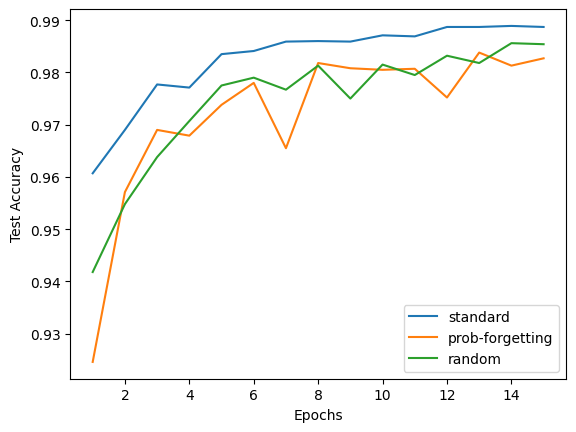

In [ ]:
# Plot test accuracies
for model_name, accuracies in test_accuracies.items():
  if len(accuracies) != epochs + 1:
    continue
  x_epochs = np.arange(1, epochs + 1)
  plt.plot(x_epochs, accuracies[1:], label=model_name)
  plt.xlabel('Epochs')
  plt.ylabel('Test Accuracy')
  plt.legend()
plt.show()

In [ ]:
test_accuracies['random'] = [0] + test_accuracies['random']

In [ ]:
!python --version

Python 3.10.12


In [ ]:
# Plot test accuracies for balanced epochs
for model_name, accuracies in test_accuracies.items():
  if model_name == 'standard':
    x_epochs = np.arange(0, epochs)
  else:
    x_epochs = np.arange(0, epochs) * B_b
  plt.plot(x_epochs, accuracies, label=model_name)
plt.title(f'Test Accuracy on CIFAR-10 with n_b/n_B = {B_b}')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()